<a href="https://colab.research.google.com/github/shubymao/comp551-p3/blob/vic/Project_3_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - Convolution Neural Network

## Team Members

Le-Li Mao (260800098)

Victor Livernoche (260926276)

Enan Ashaduzzaman (260805923)

## Initializing Dependency

In [1]:
from __future__ import print_function
import pickle as pkl
import numpy as np
import argparse
from tqdm import tqdm
from sklearn.preprocessing import normalize

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import pandas as pd

%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import string
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


## Loading Data

In [27]:
mapping = list(string.ascii_lowercase) 
training_data, training_labels, testing_data = None, None, None
with open("/content/drive/My Drive/data/images_l.pkl", 'rb') as f: 
    training_data = pkl.load(f)
with open("/content/drive/My Drive/data/labels_l.pkl", 'rb') as f: 
    training_labels = pkl.load(f)
with open("/content/drive/My Drive/data/images_test.pkl", 'rb') as f: 
    testing_data = pkl.load(f)
with open("/content/drive/My Drive/data/images_ul.pkl", 'rb') as f: 
    unlabeled_data = pkl.load(f)

## Preprocessing

Create the pipeline for handling data

In [ ]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [3]:
def nomalize_img(img):
  cliped_img = np.clip(img, 0, 255)
  subtracted_img = cliped_img - cliped_img.mean() + 10
  normalized_img = subtracted_img / np.max(subtracted_img) * 255
  return normalized_img

In [53]:
def extract_key_item(original, padding=2, threshold=100 , show_all = False, debug=False):
  stages = None
  img = cv2.normalize(original, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  #img = cv2.fastNlMeansDenoising(img, None, 3, 3)
  img_blur = cv2.GaussianBlur(img, (7, 7), 0)
  (_, thresh) = cv2.threshold(img_blur, 65, 255, cv2.THRESH_BINARY)
  if debug: plt.imshow(img_blur); plt.show()
  if debug: plt.imshow(thresh); plt.show()
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
  key_items = []
  bounding_box_cords = []
  for c in contours:
      x,y,w,h = cv2.boundingRect(c)
      if show_all or debug: cv2.rectangle(img, (x, y), (x + w, y + h), 255, 1)
      if(w < 10 and h < 10): # select elements with at least 10px width or 10 px height
        continue
      dup = False
      for (px, py) in bounding_box_cords:
        if abs(px-x)+abs(py-y) < 10:
          dup = True
      if dup: continue   
      key_items.append(original[y-padding:y+h+padding,x-padding:x+w+padding].copy())
      
      bounding_box_cords.append((x,y,))
  if show_all: 
    stages = [img_blur, thresh, img]
  if debug: plt.imshow(img); plt.show()
  return stages, key_items

In [5]:
def pad_to_fixed_size(img, width, height):
  row, col = img.shape
  if row > height or col > width: 
    return None
  pl = (width - col)// 2
  pt = (height - row)// 2
  pr = (width - col - pl)
  pb = (height - row - pt)
  return np.pad(img, [(pt,pb),(pl,pr)], 'constant')

In [6]:
def merge_key_items(key_items):
  if len(key_items) >= 2:
    item1 = pad_to_fixed_size(key_items[0],28,56)
    item2 = pad_to_fixed_size(key_items[1],28,56)
    if item1 is None or item2 is None: return None
    result = np.concatenate((item1,item2), axis = 1)
    return result 
  return None

In [7]:
def pre_processing(original, show_all=False, debug=False):
  normalized_img = nomalize_img(original.copy())
  if debug: plt.imshow(normalized_img); plt.show()
  extract_stages, key_items = extract_key_item(normalized_img, show_all=show_all, debug=debug)
  if debug: [(plt.imshow(item), plt.show()) for item in key_items]
  result = merge_key_items(key_items)
  #result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  #result = cv2.fastNlMeansDenoising(result, None, 3, 7)
  #result = cv2.threshold(result, 65, 255, cv2.THRESH_BINARY)
  #result = np.asarray(result)
  if result is None: return normalized_img, None, False
  stages = None
  if show_all:
    stages = [original, normalized_img, *extract_stages, *key_items, result]
  return result, stages, True

In [8]:
def convert_labels_to_readables(labels):
  readables = []
  for label in labels:
    l1 = np.argmax(label[0:10])
    l2 = mapping[np.argmax(label[10:])]
    readables.append((l1,l2,))
  return readables

In [9]:
# show images
def img_grid(row,col,imgs):
  if imgs is None: return
  for r in range(row):
    fig, axs = plt.subplots(nrows=1, ncols=col, figsize=(7.,10.))
    for i, ax in enumerate(axs.flatten()):
        if(len(imgs) <= r*col+i): 
          return
        plt.sca(ax)
        plt.imshow(imgs[r*col+i])
        #plt.colorbar()
    plt.show()

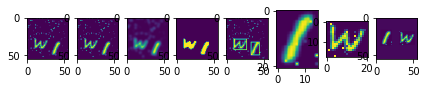

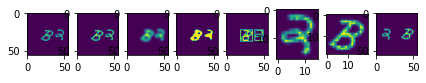

In [10]:
# Test the preprocessing functions
for ind in np.random.choice(training_data.shape[0], 3, replace=False):
  img = training_data[ind]
  _, stages,_ = pre_processing(img, show_all=True)
  if stages is not None: img_grid(1,len(stages),stages)

In [11]:
# transform all data to the output format
def process_data(data):
  output, bad_index = [], []
  for i in range(len(data)):
      result,_,valid = pre_processing(data[i])
      output.append(result)
      if not valid:
        bad_index.append(i)
  output = np.array(output).astype('float64')
  return output, bad_index

def normalize_data(data):
  output = []
  for i in range(len(data)):
      output.append(nomalize_img(data[i].copy()))
  output = np.array(output).astype('float64')
  return output

In [54]:
normalized_training_data = normalize_data(training_data)
processed_training_data, bad_training_index = process_data(training_data)

print(f'Number of training data element unable to be separated: {len(bad_training_index)}')
processed_training_data = np.delete(processed_training_data, bad_training_index, axis=0)
processed_training_labels = np.delete(training_labels, bad_training_index, axis=0)
# We append the processed to original as additional training data
final_training_data = np.append(normalized_training_data, processed_training_data, axis=0)
final_training_labels = np.append(training_labels, processed_training_labels, axis=0)

print(final_training_data.shape)
print(final_training_labels.shape)

normalized_unlabeled_data = normalize_data(unlabeled_data)
processed_unlabeled_data, bad_unlabeled_index = process_data(unlabeled_data)

print(f'Number of training data element unable to be separated: {len(bad_unlabeled_index)}')
processed_unlabeled_data = np.delete(processed_unlabeled_data, bad_unlabeled_index, axis=0)
# We append the processed to original as additional training data

final_unlabeled_data = np.append(normalized_unlabeled_data, processed_unlabeled_data, axis=0)

print(final_unlabeled_data.shape)

# Clean up to reduce memory footprint
training_data, processed_training_data, normalized_training_data = None, None, None
training_labels, processed_training_labels = None, None
unlabeled_data, processes_unlabeled_data, normalized_unlabeled_data = None, None, None

KeyboardInterrupt: ignored

In [13]:
processed_testing_data, bad_testing_index = process_data(testing_data)
print(f'Number of test data element unable to be processed: {len(bad_testing_index)}')
print(np.shape(processed_testing_data))
testing_data = None

Number of test data element unable to be processed: 2066
(15000, 56, 56)


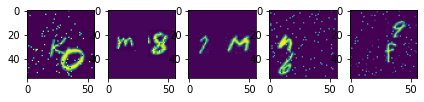

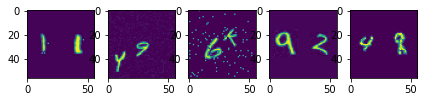

[(0, 'k'), (8, 'm'), (7, 'm'), (6, 'n'), (9, 'f'), (1, 'i'), (9, 'y'), (6, 'k'), (2, 'q'), (4, 'q')]


In [14]:
def show_random_sample(n):
  index = np.random.choice(final_training_data.shape[0], n, replace=False)  
  img_grid(n//5,5,final_training_data[index])
  print(convert_labels_to_readables(final_training_labels[index]))
show_random_sample(10)

Put the data into dataloader

In [15]:
training_tensor = torch.from_numpy(final_training_data[:,None]).float()
number_label_tensor = torch.from_numpy(np.argmax(final_training_labels[:,0:10],1))
letter_label_tensor = torch.from_numpy(np.argmax(final_training_labels[:,10:36],1))
multi_label_tensor = torch.stack((number_label_tensor,letter_label_tensor), axis=1)

# mixed_label_tensor = torch.cat((number_label_tensor, letter_label_tensor), 0)
# mixed_training_tensor = torch.cat((training_tensor, training_tensor), 0)
# mixed_training_dataset = TensorDataset(mixed_training_tensor, mixed_label_tensor)
# mixed_training_dataloader = DataLoader(mixed_training_dataset, batch_size=30, shuffle=True, num_workers=2)

multi_training_dataset = TensorDataset(training_tensor, multi_label_tensor)
#multi_training_dataloader = DataLoader(multi_training_dataset, batch_size=30, shuffle=True, num_workers=2)

train_size = int(0.9*len(multi_training_dataset))
validation_size = len(multi_training_dataset)-train_size

multi_training_dataset, multi_validation_dataset = random_split(multi_training_dataset, [train_size, validation_size])
multi_training_dataloader = DataLoader(multi_training_dataset, batch_size=30, shuffle=True, num_workers=2)
multi_validation_dataloader = DataLoader(multi_validation_dataset, batch_size=30, shuffle=True, num_workers=2)

training_tensor, number_label_tensor, multi_label_tensor = None, None, None
final_training_data, final_training_labels = None, None

## Training Model

Initialize network validation and training function

In [16]:
def validate_model(model, validation_dataloader):
  digit_acc, letter_acc = 0, 0
  for i, validation_data in enumerate(tqdm(validation_dataloader)):
    inputs, labels = validation_data
    o1, o2 = model(inputs)
    l1, l2 = labels[:,0], labels[:,1]
    digit_acc += torch.mean((torch.argmax(o1, dim=1) == l1).float()).float()
    letter_acc += torch.mean((torch.argmax(o2, dim=1) == l2).float())
  digit_acc = digit_acc/len(validation_dataloader)
  letter_acc = letter_acc / len(validation_dataloader)
  return (digit_acc.item(), letter_acc.item())

In [17]:
def train_network(net, dataloader, validation_dataloader, lr = 0.005, momentum = 0.9, max_epoch = 7, criterion = nn.CrossEntropyLoss()):
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
  running_loss = 0.0
  digits_accs, letter_accs = [], []
  for epoch in range(max_epoch):  # loop over the dataset multiple times
      cnt = 0
      for i, data in enumerate(tqdm(dataloader)):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          cnt+=1
      # print training statistics
      print('[%d] loss: %.3f' % (epoch + 1, running_loss / cnt))
      running_loss = 0.0
      digit_acc, letter_acc = validate_model(net, validation_dataloader)
      print(digit_acc)
      print(letter_acc)
      digits_accs.append(digit_acc)
      letter_accs.append(letter_acc)
  return (digits_accs, letter_accs)

### Multi-Output Model

Initalize the Multilabel Model

In [18]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 6, padding=1)
        self.conv2 = nn.Conv2d(64, 256, 4, padding=1, stride=1)
        self.conv3 = nn.Conv2d(256, 256, 3, padding='same')
        self.conv4 = nn.Conv2d(256, 256, 3, padding='same')
        self.conv5 = nn.Conv2d(256, 128, 3, padding='same')
        # 3 Dense Layer
        self.fc11 = nn.Linear(3200, 2000)  
        self.fc21 = nn.Linear(3200, 2000)  
        self.fc12 = nn.Linear(2000, 1000)
        self.fc22 = nn.Linear(2000, 1200)
        self.fc13 = nn.Linear(1000, 10)
        self.fc23 = nn.Linear(1200, 26)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 3)
        x = F.max_pool2d(F.relu(self.conv2(x)), 3)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        # print(x.size())
        x = x.view(-1,self.num_flat_features(x)) # Flatten
        
        x1 = F.relu(self.fc11(x))
        x1 = F.relu(self.fc12(x1))
        l1 = self.fc13(x1)

        x2 = self.fc21(x)
        x2 = self.fc22(x2)
        l2 = self.fc23(x2)
        return l1,l2
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

100%|██████████| 1672/1672 [09:09<00:00,  3.04it/s]


[1] loss: 4.621


100%|██████████| 186/186 [00:20<00:00,  9.27it/s]


0.6262810230255127
0.37339088320732117


100%|██████████| 1672/1672 [09:27<00:00,  2.95it/s]


[2] loss: 2.252


100%|██████████| 186/186 [00:20<00:00,  9.24it/s]


0.8519327044487
0.6375558376312256


100%|██████████| 1672/1672 [09:29<00:00,  2.94it/s]


[3] loss: 1.251


100%|██████████| 186/186 [00:20<00:00,  9.11it/s]


0.8942805528640747
0.7528281211853027


100%|██████████| 1672/1672 [09:31<00:00,  2.93it/s]


[4] loss: 0.786


100%|██████████| 186/186 [00:20<00:00,  9.19it/s]


0.914889931678772
0.7990652322769165


100%|██████████| 1672/1672 [09:30<00:00,  2.93it/s]


[5] loss: 0.516


100%|██████████| 186/186 [00:20<00:00,  9.25it/s]


0.9307698011398315
0.8298351168632507


100%|██████████| 1672/1672 [09:29<00:00,  2.94it/s]


[6] loss: 0.362


100%|██████████| 186/186 [00:20<00:00,  9.24it/s]


0.928081214427948
0.8394423723220825


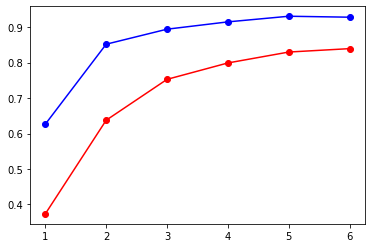

In [19]:
def train_model(dataloader, epoch):
  multi_net = MultiNet()
  multi_net_criterion = nn.CrossEntropyLoss()
  lr = 0.001
  def ml_criterion(output, labels):
    o1, o2 = output
    l1, l2 = labels[:,0], labels[:,1]
    loss1 = multi_net_criterion(o1,l1)
    loss2 = multi_net_criterion(o2,l2)
    return loss1 + loss2
  res = train_network(multi_net, dataloader, multi_validation_dataloader, criterion=ml_criterion, lr=lr, max_epoch=epoch)
  digit_accuracies, letter_accuracies = res
  plt.plot(range(1, epoch+1), digit_accuracies, 'bo-')
  plt.plot(range(1, epoch+1), letter_accuracies, 'ro-')
  return multi_net
multi_net = train_model(multi_training_dataloader, 6)
# save to download if it crashes
from os.path import exists
torch.save(multi_net.state_dict(), 'checkpoint.pth')

In [49]:
# find labels on unlabeled data
#state_dict = torch.load('checkpoint.pth')
#multi_net = MultiNet()
#multi_net.load_state_dict(state_dict)

labels = []
k = 0
while(k<30000):
  l1,l2 = multi_net(torch.from_numpy(final_unlabeled_data[k:k+500, None]).float())
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    labels.append([l1[i], l2[i]])
    k += 1
unlabeled_labels = np.array(labels)

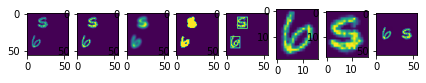

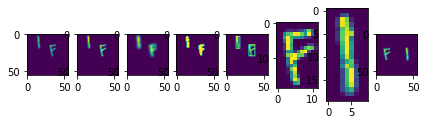

In [50]:
for img in unlabeled_data[0:3, :]:
  _, stages,_ = pre_processing(img, show_all=True)
  if stages is not None: img_grid(1,len(stages),stages)

In [ ]:
unlabeled_tensor = torch.from_numpy(final_unlabeled_data[:,None]).float()

processed_unlabeled_labels = np.delete(unlabeled_labels, bad_unlabeled_index, axis=0)
final_unlabeled_labels = np.append(unlabeled_labels, processed_unlabeled_labels, axis=0)

unlabeled_dataset = TensorDataset(unlabeled_tensor, torch.from_numpy(final_unlabeled_labels))
final_training_dataset = torch.utils.data.ConcatDataset([multi_training_dataset, unlabeled_dataset])

final_training_dataloader = DataLoader(final_training_dataset, batch_size=30, shuffle=True, num_workers=2)
# train with the training and unlabeled data
multi_net = train_model(final_training_dataloader, 10)
from os.path import exists
torch.save(multi_net.state_dict(), 'checkpoint2.pth')

 60%|██████    | 2137/3533 [12:24<08:08,  2.86it/s]

## Testing Model

Test the multi output network

In [ ]:
img_grid(2,5,final_training_data[200:210])
l1,l2 = multi_net(torch.from_numpy(final_training_data[200:210,None]).float())
letter_prediction = list(map(lambda x: mapping[x], np.argmax(l2.detach().numpy(),axis=1)))
prediction = list(zip(np.argmax(l1.detach().numpy(),axis=1),letter_prediction))
print(prediction)

In [32]:
!pip install scikit-learn
from sklearn.metrics import confusion_matrix
validation_data, validation_labels = multi_validation_dataset[:]

l1,l2 = multi_net(validation_data)

accuracy_digits = np.mean(np.argmax(l1.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 0])
accuracy_letters = np.mean(np.argmax(l2.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 1])
#accuracy = np.mean(np.all(np.argmax(l1.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 0], np.argmax(l2.detach().numpy(), axis=1)==validation_labels.detach().numpy()[:, 1]))
print(confusion_matrix(validation_labels.detach().numpy()[:, 0], np.argmax(l1.detach().numpy(), axis=1)))
print(confusion_matrix(validation_labels.detach().numpy()[:, 1], np.argmax(l2.detach().numpy(), axis=1)))

print(accuracy_digits)
print(accuracy_letters)
#print(accuracy)
#and np.argmax(l2.detach().numpy(), axis=1)==np.argmax(final_training_labels[None, 11:27], axis=1)))

[[506  12   8   2   1   7   2   3   2   8]
 [  2 521   4   2   2   3   2   8   1   4]
 [  4   6 574   2   5   2   1   3   3   6]
 [  2   6   8 485   0   3   0   9   2   2]
 [  9  10   8   0 497   4   0   3   2  14]
 [  9   6   7   2   0 510   1   0   1   8]
 [ 21  14  10   1   1  13 500   3   5   5]
 [  2   2   4   3   2   1   0 541   0   2]
 [ 16   7   8   5   0   7   0   3 517   6]
 [  5   1   6   0  11   3   0   9   4 521]]
[[142   1   0   2   0   0   1   4   1   0   0   1   3   0   0   0  22   1
    2   1   0   0   3   0   0   0]
 [  3 169   0   6   0   0   2   7   2   0   0   0   0   1   3   1   6   0
    3   0   0   0   1   0   0   2]
 [  9   0 157   0   6   1   1   1   4   0   0   1   0   0   0   0   3   1
    0   0   0   0   0   0   1   1]
 [  2   0   0 212   0   0   0   1   0   8   0   0   2   2   8   1   0   0
    0   1   1   0   0   0   0   0]
 [  3   1   3   1 215   5   7   1   1   0   0   0   0   0   0   1   0   3
    1   2   3   0   0   0   0   0]
 [  0   1   0   2   1 21

## Results

In [ ]:
def LabelToString(label, isDigit):
  s = ""
  r = 0
  if (isDigit):
    r = 10
  else:
    r = 26
  for i in range(0, r):
    if (i == label):
      s += '1'
    else:
      s += '0'
  return s

category = []
k = 0
while(k<15000):
  l1,l2 = multi_net(torch.from_numpy(processed_testing_data[k:k+100, None]).float())
  l1 = np.argmax(l1.detach().numpy(), axis=1)
  l2 = np.argmax(l2.detach().numpy(), axis=1)
  for i in range(0, len(l1)):
    a = LabelToString(l1[i], True)
    b = LabelToString(l2[i], False)
    category.append(a+b)
    k += 1

In [ ]:
id = []
for i in range(0, 15000):
  id.append(i)
# need to create data dict
data = {
    '# Id' : id,
    'Category' : category
}

df = pd.DataFrame(data=data, columns= ['# Id', 'Category'])
print(df)
df.to_csv('/content/drive/My Drive/data/results.csv', index = False, header=True)